Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [1]:
HYPERTRAINING = False
CV = 5
SCORING = 'r2'
AUTO_FEATURE_SELECT = 'backward'
# forward eher schlecht
#'neg_mean_squared_error'   nope
#r2 sehr gut -> 0.45
# 'explained_variance'
# HUBER
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
EXPERIEMENT_NAME = "offense_potential_winger"
SAVE_MODEL_NAME = EXPERIEMENT_NAME
CLASS_WEIGHTS = 'balanced'

RUN_NAME = None
TARGET_OVERALL = 78

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackleshooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']
PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','shooting_technique','mental',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl',  'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  
        'youth_player', 'shooting', 
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Reactions',
       'age_based_physique', 'age_based_shooting_technique',
       'age_based_Stamina', 'age_based_Positioning', 'age_based_Vision',
       'age_based_Finishing', 'age_based_BallControl']

PLAYER_ATTRIBUTES = [ 'Finishing',
       'ShortPassing', 'Dribbling',  'FKAccuracy',
       'BallControl',  'SprintSpeed', 'Agility',
       'Reactions', 'Balance',  
       'Positioning'        ]


In [2]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw_datadf_raw
from src.sport_analytics.model.eval import plot_feature_importance,plot_shap_summary,plot_auc_curves
import config as CONFIG

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Get Data

In [3]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,age_based_Reactions,age_based_Dribbling,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl,age_based_shooting
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,19.322854,33.796856,-2.312576,31.146554,4.535671,32.956469,29.762999,38.114873,29.291415,34.732366
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,16.004264,29.656716,10.965885,32.690832,12.825160,29.906183,16.801706,35.034115,27.253731,33.610519
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,15.187647,22.799062,9.627834,17.967787,11.164191,19.322909,17.932760,22.726349,18.115715,17.524889
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,16.753945,22.654950,3.631636,21.288953,11.442611,26.479197,26.281923,26.463415,22.559541,24.319464
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,16.753945,22.654950,1.631636,22.688953,18.442611,29.479197,15.281923,28.463415,16.559541,28.986131


# 

In [5]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'train', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [6]:
df = df[df.winger == 1]

# Training nur auf High Potentials
df = df[df.max_potential>TARGET_OVERALL]

# nur Entwicklugnsfähige Spieler
df = df[df.prime_age>df.potential_age]
df = df[df.PrimeOverall>df.Overall]
df['target'] = df.PrimeOverall
df = df[df.potential_age<23]

df = df[df.offense>0.5]
print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
77.0    30
74.0    20
71.0    17
79.0    16
75.0    16
76.0    16
78.0    15
68.0    15
72.0    14
73.0    14
69.0    14
67.0    12
70.0    10
65.0     8
84.0     8
81.0     7
82.0     7
83.0     6
85.0     4
66.0     4
80.0     4
64.0     4
87.0     3
86.0     2
63.0     2
88.0     2
91.0     2
89.0     2
60.0     1
58.0     1
92.0     1
62.0     1
90.0     1
Name: count, dtype: int64


In [7]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
183277,E. Hazard,2011,19.0,19.0,27.0,91.0,91.0,81.0,91.0,91.0,drop,RW
243812,Rodrygo,2021,19.0,19.0,21.0,90.0,90.0,79.0,81.0,81.0,test,RW
208790,Z. Bakkali,2014,17.0,17.0,20.0,90.0,90.0,73.0,74.0,74.0,train,RW
255475,Antony,2021,20.0,20.0,22.0,88.0,88.0,78.0,82.0,82.0,test,RW
246045,P. De la Vega,2020,18.0,18.0,22.0,88.0,88.0,70.0,75.0,75.0,test,RW


In [8]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [9]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Marking', 'Composure', 'Defensive awareness', 'mental'], dtype='object')

#### Transform Value

In [10]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

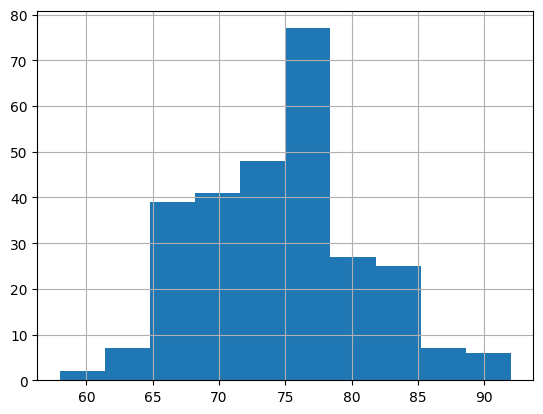

In [11]:
df['target'].hist()

In [12]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [13]:
df_processed.columns

Index(['potential_age', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Position', 'Unnamed: 0', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Composure',
       'Defensive awareness', 'max_potential', 'prime_age', 'PrimeOverall',
       'best_position', 'central', 'winger', 'offense', 'Defense',
       'overall_age_ratio', 'youth_player', 'shooting', 'shooting_technique',
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Strength',
       'age_based_React

In [14]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [15]:
y_train.describe()

count    138.000000
mean      75.717391
std        5.694137
min       63.000000
25%       72.250000
50%       76.000000
75%       79.000000
max       92.000000
Name: target, dtype: float64

In [16]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [17]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


In [18]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


In [19]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Ridge Regression training----->


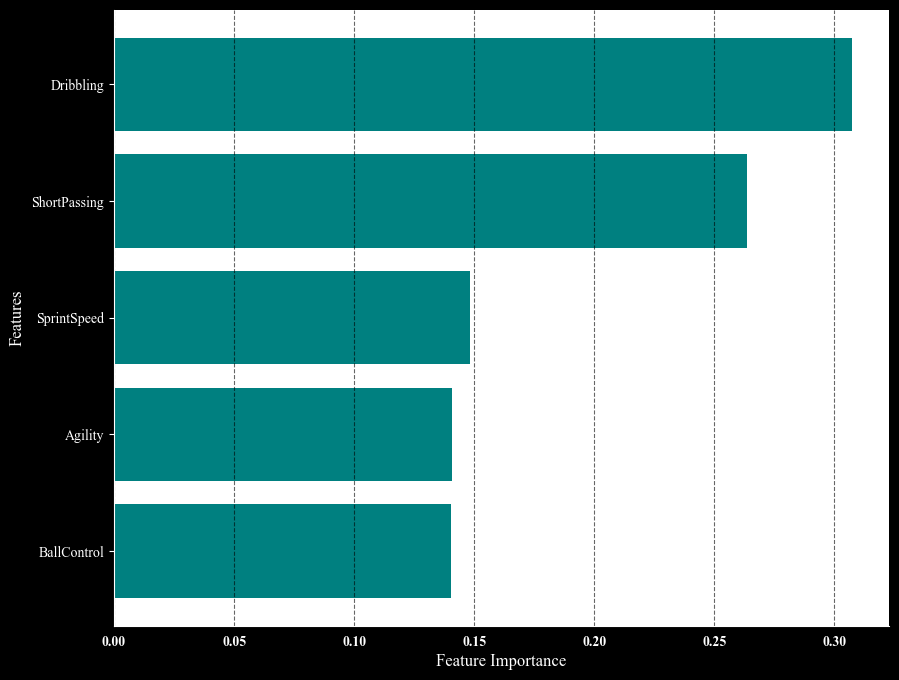

100%|██████████| 30/30 [00:00<00:00, 37.06it/s]


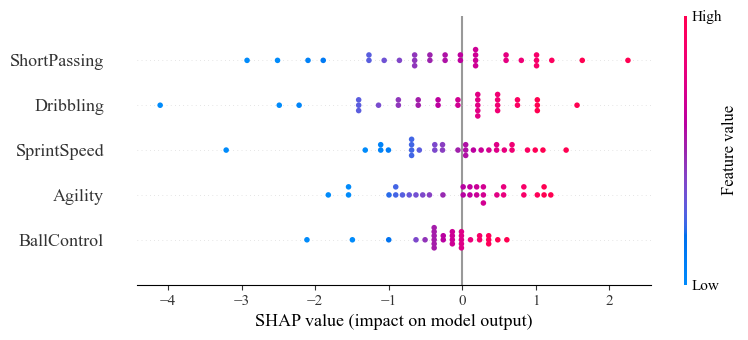

              precision    recall  f1-score   support

       False       0.93      0.93      0.93        46
        True       0.50      0.50      0.50         6

    accuracy                           0.88        52
   macro avg       0.72      0.72      0.72        52
weighted avg       0.88      0.88      0.88        52

Huber Regression training----->


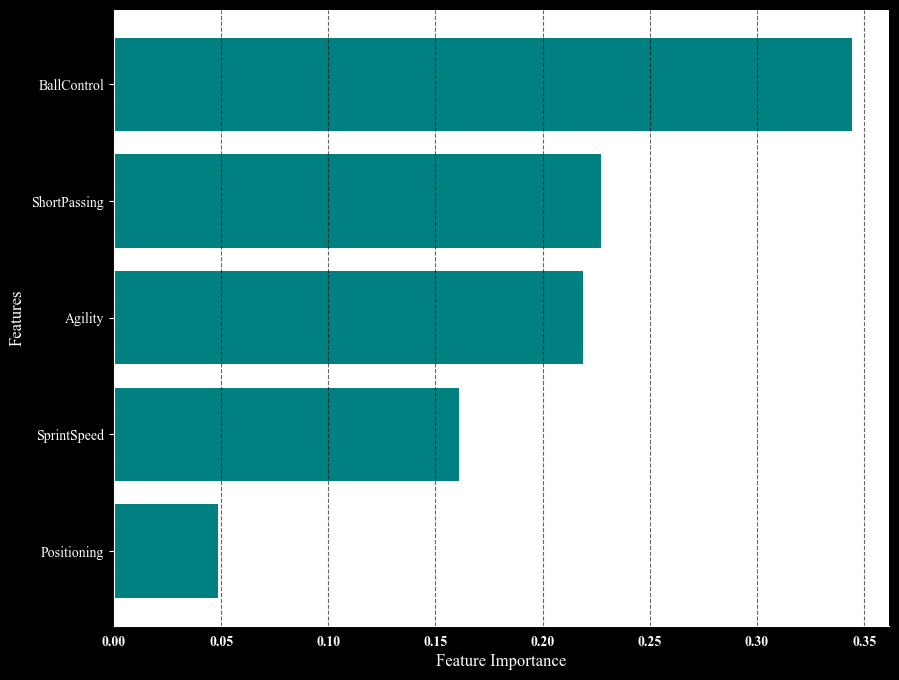

100%|██████████| 30/30 [00:00<00:00, 64.29it/s]


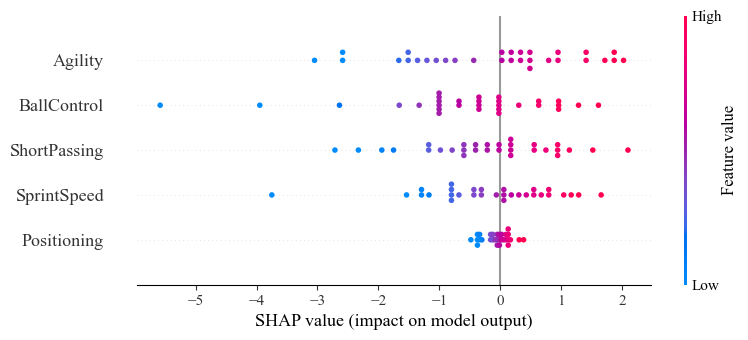

              precision    recall  f1-score   support

       False       0.93      0.89      0.91        46
        True       0.38      0.50      0.43         6

    accuracy                           0.85        52
   macro avg       0.65      0.70      0.67        52
weighted avg       0.87      0.85      0.86        52

Linear Regression training----->


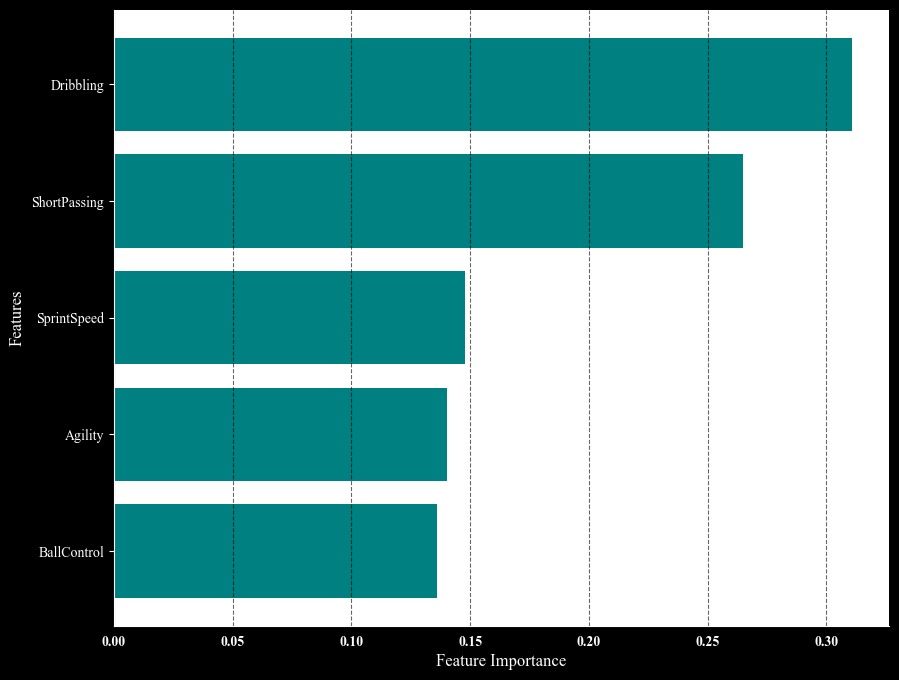

100%|██████████| 30/30 [00:01<00:00, 29.65it/s]


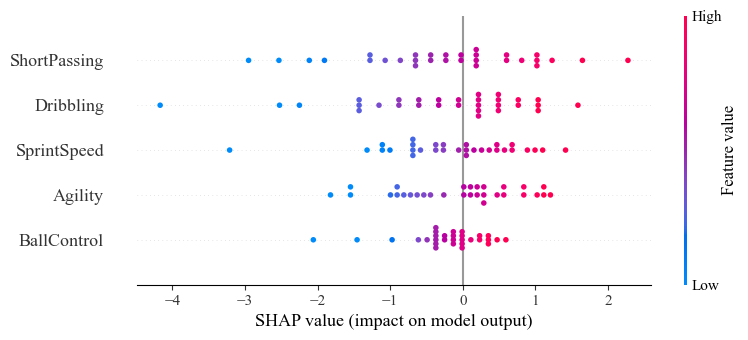

              precision    recall  f1-score   support

       False       0.93      0.91      0.92        46
        True       0.43      0.50      0.46         6

    accuracy                           0.87        52
   macro avg       0.68      0.71      0.69        52
weighted avg       0.88      0.87      0.87        52

Model: Ridge Regression
Mean Squared Error: 20.35
Mean Absolute Error: 3.72
R2 Score: 0.34

Model: Huber Regression
Mean Squared Error: 20.46
Mean Absolute Error: 3.71
R2 Score: 0.33

Model: Linear Regression
Mean Squared Error: 20.33
Mean Absolute Error: 3.71
R2 Score: 0.34



In [20]:
from sklearn.linear_model import LinearRegression,HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

from src.sport_analytics.model.eval import plot_feature_importance, log_metrics_in_mlflow_regression,log_metrics_in_mlflow, log_feature_list_as_artifact, plot_shap_summary
from src.sport_analytics.utils import *
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor

regression_models = {
    'Ridge Regression': Ridge(**PARAMS_RIDGE),
    'Huber Regression':HuberRegressor(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    # 'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
    # 'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
    # 'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}
import datetime
# Set the experiment name
mlflow.set_experiment(EXPERIEMENT_NAME)

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():
    from datetime import datetime

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())
        from sklearn.feature_selection import SelectFromModel
        
        # featres = X_train_scaled_df.columns
        if AUTO_FEATURE_SELECT == 'AUTO':
            sfm = SelectFromModel(model).fit(X_train_scaled_df, y_train)
            features = X_train_scaled_df.columns[sfm.get_support()]
        elif AUTO_FEATURE_SELECT in  ['backward','forward']:
            from sklearn.feature_selection import SequentialFeatureSelector
            sfm = SequentialFeatureSelector(
                model, direction=AUTO_FEATURE_SELECT
            ).fit(X_train_scaled_df, y_train)
            features = X_train_scaled_df.columns[sfm.get_support()]
        else:
            features = X_train_scaled_df.columns
        

        model.fit(X_train_scaled_df[features], y_train)
       
        y_pred = model.predict(X_test_scaled_df[features])
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(features),
            # 'y_train_positives': y_train.sum(),
            # 'y_train_negatives': (~y_train).sum(),
            # 'y_test_positives': y_test.sum(),
            # 'y_test_negatives': (~y_test).sum(),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df[features])
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        plot_shap_summary(model=model,df=X_test_scaled_df[features],K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        from sklearn.metrics import  classification_report
        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'attributes': features,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [21]:
from src.sport_analytics.model.utils import *
if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.TRAINED_MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [22]:
X_train.describe()

,Finishing,ShortPassing,Dribbling,FKAccuracy,BallControl,SprintSpeed,Agility,Reactions,Balance,Positioning
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,63.717391,64.079710,74.159420,52.637681,71.782609,80.507246,78.731884,63.449275,74.108696,64.028986
std,7.091672,6.275967,5.618331,11.359386,5.595539,6.958948,7.567255,8.549617,10.498304,7.137791
min,36.000000,47.000000,57.000000,24.000000,58.000000,63.000000,54.000000,36.000000,26.000000,43.000000
25%,59.250000,59.250000,70.000000,44.000000,68.000000,77.000000,74.000000,58.000000,68.000000,60.000000
50%,64.000000,64.000000,75.000000,53.000000,72.000000,80.500000,79.000000,64.000000,75.000000,65.000000
75%,68.000000,69.000000,78.000000,62.000000,75.000000,85.000000,84.000000,69.000000,81.000000,69.000000
max,84.000000,77.000000,90.000000,76.000000,92.000000,95.000000,95.000000,84.000000,92.000000,88.000000


In [23]:
y_test.describe()

count    52.000000
mean     72.365385
std       5.590710
min      60.000000
25%      67.750000
50%      73.000000
75%      77.000000
max      84.000000
Name: target, dtype: float64

In [24]:
my_model = regression_results['Huber Regression']['Model']
my_features = regression_results['Huber Regression']['attributes']


In [25]:
result_df = pd.Series(my_model.predict(X_test_scaled_df[my_features]),index=X_test_scaled_df.index)
len(result_df)

52

<Axes: >

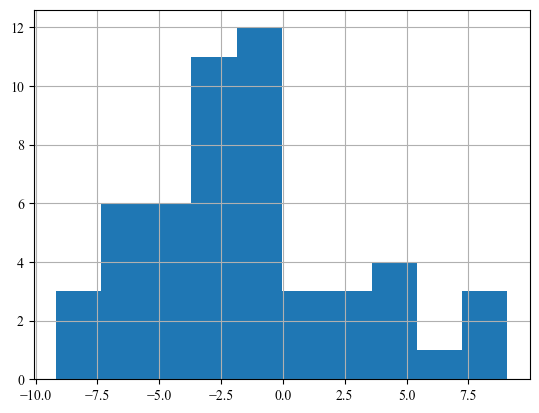

In [26]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

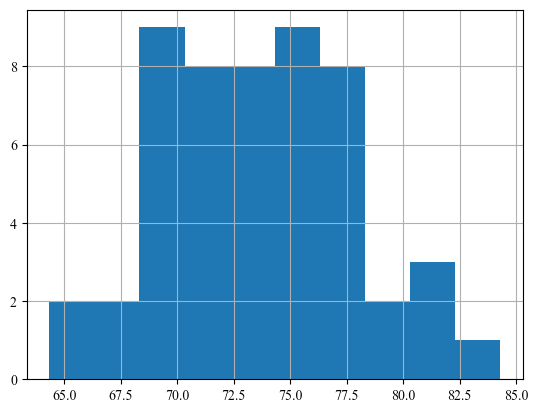

In [27]:
result_df.sort_values(ascending=False).hist()

In [28]:
(y_test-result_df).describe()

count    52.000000
mean     -1.353062
std       4.358187
min      -9.171296
25%      -4.307896
50%      -1.990049
75%       0.345853
max       9.065364
dtype: float64

In [29]:
outlier = (y_test-result_df)>3
X_test[outlier]


,,,Finishing,ShortPassing,Dribbling,FKAccuracy,BallControl,SprintSpeed,Agility,Reactions,Balance,Positioning
ID,Name,FIFA,,,,,,,,,,
246174,H. Elliott,2021,54.0,63.0,72.0,42.0,66.0,72.0,83.0,58.0,80.0,62.0
251566,Gabriel Martinelli,2020,62.0,64.0,73.0,49.0,73.0,84.0,76.0,51.0,69.0,62.0
242964,A. Gordon,2021,62.0,62.0,71.0,59.0,68.0,73.0,63.0,59.0,66.0,61.0
240273,E. Smith Rowe,2020,62.0,61.0,68.0,58.0,67.0,79.0,75.0,55.0,68.0,62.0
256516,Nico Williams,2021,66.0,59.0,68.0,57.0,66.0,76.0,69.0,51.0,65.0,62.0
246785,Bryan Gil,2020,60.0,60.0,72.0,52.0,69.0,69.0,77.0,59.0,74.0,60.0
237712,V. Castellanos,2020,68.0,63.0,66.0,35.0,64.0,72.0,70.0,53.0,68.0,63.0
246431,R. Sottil,2021,60.0,60.0,68.0,45.0,68.0,78.0,72.0,58.0,75.0,62.0
231836,J. Karlsson,2021,68.0,57.0,75.0,60.0,69.0,79.0,92.0,65.0,90.0,66.0


In [30]:
y_test[outlier]

ID      Name                FIFA
246174  H. Elliott          2021    77.0
251566  Gabriel Martinelli  2020    84.0
242964  A. Gordon           2021    75.0
240273  E. Smith Rowe       2020    78.0
256516  Nico Williams       2021    79.0
246785  Bryan Gil           2020    77.0
237712  V. Castellanos      2020    79.0
246431  R. Sottil           2021    76.0
231836  J. Karlsson         2021    78.0
Name: target, dtype: float64

In [31]:
result_df[outlier]

ID      Name                FIFA
246174  H. Elliott          2021    72.548852
251566  Gabriel Martinelli  2020    75.426482
242964  A. Gordon           2021    70.025029
240273  E. Smith Rowe       2020    72.121732
256516  Nico Williams       2021    70.120641
246785  Bryan Gil           2020    71.590543
237712  V. Castellanos      2020    69.934636
246431  R. Sottil           2021    71.672725
231836  J. Karlsson         2021    74.761533
dtype: float64

In [32]:
(y_test/result_df).describe()

count    52.000000
mean      0.982060
std       0.059924
min       0.877849
25%       0.940707
50%       0.974628
75%       1.004576
max       1.129626
dtype: float64

In [33]:
(y_test/result_df).describe()

count    52.000000
mean      0.982060
std       0.059924
min       0.877849
25%       0.940707
50%       0.974628
75%       1.004576
max       1.129626
dtype: float64

In [34]:
np.corrcoef(y_test,result_df)

array([[1.        , 0.63702005],
       [0.63702005, 1.        ]])

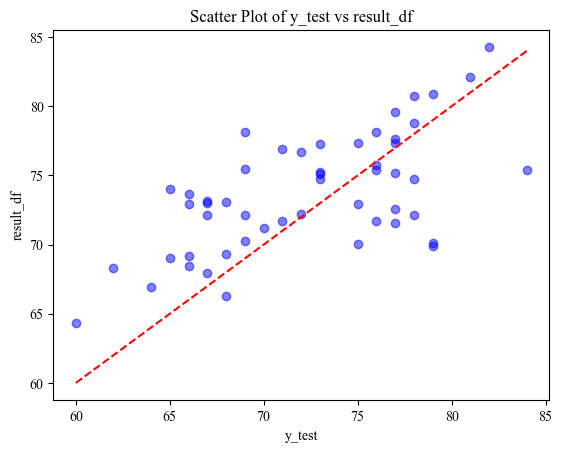

In [35]:
import matplotlib.pyplot as plt
plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [36]:
result_df = result_df.sort_values(ascending=False)

In [37]:
result_df.head(50)

ID      Name                FIFA
255475  Antony              2021    84.290865
243812  Rodrygo             2021    82.135801
253004  Ansu Fati           2021    80.852680
244193  Jovane Cabral       2021    80.778673
247181  G. Plata            2021    79.557593
243014  B. Mbeumo           2021    78.784717
248113  A. Mățan            2021    78.171296
241907  D. Rossi            2020    78.132692
220710  H. Wilson           2020    77.615767
246420  J. Doku             2020    77.358513
246045  P. De la Vega       2020    77.340296
253293  B. Ocampo           2021    77.300574
248060  V. Mihăilă          2021    76.936131
246145  I. Aliseda          2020    76.717331
233848  J. Hauge            2021    75.747946
251954  C. Summerville      2021    75.444021
251566  Gabriel Martinelli  2020    75.426482
238050  C. Ejuke            2020    75.372748
246423  L. Orellano         2021    75.241629
240017  A. Olsen            2020    75.148634
242162  H. Evjen            2020    75.127418
2

In [38]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

5


ID      Name           FIFA
255475  Antony         2021    84.290865
243812  Rodrygo        2021    82.135801
253004  Ansu Fati      2021    80.852680
244193  Jovane Cabral  2021    80.778673
243014  B. Mbeumo      2021    78.784717
dtype: float64

In [39]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

5


ID      Name                FIFA
251566  Gabriel Martinelli  2020    75.426482
231836  J. Karlsson         2021    74.761533
240273  E. Smith Rowe       2020    72.121732
256516  Nico Williams       2021    70.120641
237712  V. Castellanos      2020    69.934636
dtype: float64

In [40]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

5


ID      Name           FIFA
244193  Jovane Cabral  2021    80.778673
247181  G. Plata       2021    79.557593
243014  B. Mbeumo      2021    78.784717
248113  A. Mățan       2021    78.171296
241907  D. Rossi       2020    78.132692
dtype: float64

In [41]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

39


ID      Name            FIFA
252114  B. Rollheiser   2021    72.945042
245870  H. Hassan       2021    72.949043
246814  Í. Jóhannesson  2021    73.035979
242612  E. Chilufya     2021    73.076157
231442  M. Browne       2020    73.126860
248572  Pedro Brazão    2021    73.647191
246682  K. Dembélé      2021    74.044664
237512  G. Togni        2021    74.761878
242162  H. Evjen        2020    75.127418
240017  A. Olsen        2020    75.148634
246423  L. Orellano     2021    75.241629
238050  C. Ejuke        2020    75.372748
251954  C. Summerville  2021    75.444021
233848  J. Hauge        2021    75.747946
246145  I. Aliseda      2020    76.717331
248060  V. Mihăilă      2021    76.936131
253293  B. Ocampo       2021    77.300574
246045  P. De la Vega   2020    77.340296
246420  J. Doku         2020    77.358513
220710  H. Wilson       2020    77.615767
dtype: float64

In [42]:
from sklearn.metrics import  classification_report
print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.61      0.59      0.60        32
        True       0.38      0.40      0.39        20

    accuracy                           0.52        52
   macro avg       0.50      0.50      0.50        52
weighted avg       0.52      0.52      0.52        52

